In [26]:
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [27]:
os.listdir('/kaggle/input/dogs-vs-cats/')

['test1.zip', 'train.zip', 'sampleSubmission.csv']

***Extracting all the zipped files***

In [28]:
import zipfile

with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/train.zip') as zipp:
    zipp.extractall('.')
    print('Finished extracting train.zip')
    zipp.close()

with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/test1.zip') as zipp:
    zipp.extractall('.')
    print('Finished extracting test1.zip')
    zipp.close()

Finished extracting train.zip
Finished extracting test1.zip


In [29]:
print('Number of images in train directory:', len(os.listdir('/kaggle/working/train/')))
print('Number of images in test directory:', len(os.listdir('/kaggle/working/test1/')))
print('Some files from the train directory:')
print(os.listdir('/kaggle/working/train/')[:10])

Number of images in train directory: 25000
Number of images in test directory: 12500
Some files from the train directory:
['dog.10937.jpg', 'cat.30.jpg', 'dog.1747.jpg', 'cat.5999.jpg', 'dog.9814.jpg', 'dog.6736.jpg', 'cat.5349.jpg', 'dog.6544.jpg', 'cat.2628.jpg', 'cat.9005.jpg']


***Building the dataset as Dataframe***

In [30]:
train_images_path = []
train_labels = []
all_files = os.listdir('/kaggle/working/train/')

for file in all_files:
    label = file.split('.')[0]
    file_path = os.path.join('/kaggle/working/train/', file)
    train_images_path.append(file_path)
    train_labels.append(label)

In [31]:
test_images_path = []
test_labels = []
all_test_files = os.listdir('/kaggle/working/test1/')

for file in all_test_files:
    label = file.split('.')[0]
    file_path = os.path.join('/kaggle/working/test1/', file)
    test_images_path.append(file_path)
    test_labels.append(label)

In [32]:
print('Printing random record from train_images list:')
print(train_images_path[10])
print(train_labels[10])

Printing random record from train_images list:
/kaggle/working/train/dog.10416.jpg
dog


In [33]:
print('Printing random record from test_images list:')
print(test_images_path[10])
print(test_labels[10])

Printing random record from test_images list:
/kaggle/working/test1/1510.jpg
1510


In [46]:
dataframe = pd.DataFrame()
dataframe['images'] = test_images_path
dataframe['label'] = test_labels

In [35]:
print('First 10 records of dataframe.')
dataframe.head(10)

First 10 records of dataframe.


,images,label
0,/kaggle/working/train/dog.10937.jpg,dog
1,/kaggle/working/train/cat.30.jpg,cat
2,/kaggle/working/train/dog.1747.jpg,dog
3,/kaggle/working/train/cat.5999.jpg,cat
4,/kaggle/working/train/dog.9814.jpg,dog
5,/kaggle/working/train/dog.6736.jpg,dog
6,/kaggle/working/train/cat.5349.jpg,cat
7,/kaggle/working/train/dog.6544.jpg,dog
8,/kaggle/working/train/cat.2628.jpg,cat
9,/kaggle/working/train/cat.9005.jpg,cat


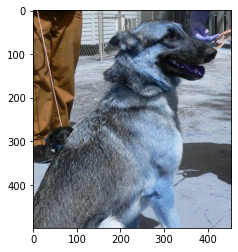

In [36]:
img = cv2.imread(train_images_path[8090])
plt.imshow(img, cmap='binary')
plt.show()

In [37]:
train_labels[8090]

'dog'

***Creating generator***

In [38]:
only_train = dataframe.loc[1:20000, :]
only_validation = dataframe.loc[20000:25000, :]

In [39]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                           horizontal_flip = True,
                                                           zoom_range=0.2)
tg = train_gen.flow_from_dataframe(dataframe=only_train,
                              x_col = 'images',
                              y_col = 'label',
                              target_size = (150, 150),
                              batch_size = 150,
                             class_mode='binary')


validation_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                           horizontal_flip = True,
                                                           zoom_range=0.2)
vg = validation_gen.flow_from_dataframe(dataframe=only_validation,
                              x_col = 'images',
                              y_col = 'label',
                              target_size = (150, 150),
                              batch_size = 150,
                                  class_mode='binary')

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


***Defining network with convolution base of pretrained VGG16 model & freezing the VGG16. We will only train a classifier on top of VGG16.***

In [40]:
def network():
    vgg_base = tf.keras.applications.vgg16.VGG16(weights = 'imagenet',
                                                 input_shape = (150,150,3),
                                               include_top = False)
    vgg_base.trainable = False
    model = tf.keras.models.Sequential()
    model.add(vgg_base)
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

***Setting a early stopping mechanism which stops the training when network starts to overfit***

In [41]:
my_model = network()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                mode='min',
                                patience=3)
result = my_model.fit(tg,
            epochs = 40,
            steps_per_epoch = (only_train.shape[0]//150),
                      validation_data = vg,
            validation_steps = (only_validation.shape[0]//150),
                     callbacks=[early_stopping])

Epoch 1/40
133/133 [==============================] - 183s 1s/step - loss: 0.3092 - accuracy: 0.8607 - val_loss: 0.2625 - val_accuracy: 0.8838
Epoch 2/40
133/133 [==============================] - 181s 1s/step - loss: 0.2367 - accuracy: 0.8979 - val_loss: 0.2320 - val_accuracy: 0.9059
Epoch 3/40
133/133 [==============================] - 181s 1s/step - loss: 0.2125 - accuracy: 0.9095 - val_loss: 0.2350 - val_accuracy: 0.8986
Epoch 4/40
133/133 [==============================] - 180s 1s/step - loss: 0.2132 - accuracy: 0.9078 - val_loss: 0.2349 - val_accuracy: 0.8984
Epoch 5/40
133/133 [==============================] - 182s 1s/step - loss: 0.2003 - accuracy: 0.9155 - val_loss: 0.2722 - val_accuracy: 0.8863


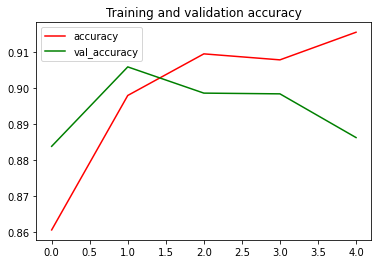

In [43]:
accuracy = result.history['accuracy']
validation_acc = result.history['val_accuracy']

epoks = range(0, len(result.history['accuracy']))

plt.plot(epoks, accuracy, 'r-', label='accuracy')
plt.plot(epoks, validation_acc, 'g-', label='val_accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()